#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
# import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
import xgboost as xgb
print(xgb.__version__)


ModuleNotFoundError: No module named 'xgboost'

#### Load dataset

In [ ]:
directory = 'data'
file_base = 'Merchants_Segments_01_'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(25, 32)] # last week of January 
# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

d =[]

# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            d.append(json.loads(line))

# Create a DataFrame
data = pd.DataFrame(d)

#### Data Preprocessing

In [ ]:
# Extract the first lat and lng as merchant coordinates
data['merchant_coords'] = list(zip(data['lats'].apply(lambda x: x[0]), data['lngs'].apply(lambda x: x[0])))

# Define the weekday column based on the dateID
data['weekday'] = data['dateID'].apply(lambda x: 1 if 27 <= x <= 30 else 0)

# Select and rename columns 
data = data[['trip_id', 'trip_time', 'driverID', 'timeID', 'dateID', 'weekday', 'merchant', 'merchant_coords']]
data = data.rename(columns={'trip_time': 'wait_time'})
data = data.rename(columns={'merchant': 'merchantID'})


In [ ]:
# Step 1: Create the 'hour' column in 'data' by converting 'timeID' to hours
data['hour'] = data['timeID'] // 60

# Step 2: Calculate order frequency per hour for each merchantID and dateID
order_frequency = data.groupby(['merchantID', 'hour', 'dateID']).size().reset_index(name='order_frequency_per_hour')

# Step 3: Merge the order frequency data back to the original data on 'merchantid', 'hour', and 'dateID'
data = data.merge(order_frequency, on=['merchantID', 'hour', 'dateID'], how='left')

# Drop the 'hour' column if it's not needed in the final DataFrame
# data = data.drop(columns=['hour'])


In [ ]:
# Define function to assign periods based on timeID
def assign_time_period(time_id):
    if 0 <= time_id < 360:         # Midnight to 6 AM
        return 'night'
    elif 360 <= time_id < 720:      # 6 AM to Noon
        return 'morning'
    elif 720 <= time_id < 1080:     # Noon to 6 PM
        return 'afternoon'
    else:                           # 6 PM to Midnight
        return 'evening'

# Apply the function to create a new 'time_period' feature
data['time_period'] = data['timeID'].apply(assign_time_period)

# Option 1: Convert 'time_period' to ordinal integers
time_period_mapping = {'night': 0, 'morning': 1, 'afternoon': 2, 'evening': 3}
data['time_period'] = data['time_period'].map(time_period_mapping)


In [ ]:
# Creating interaction terms between order_frequency_per_hour and weekday
data['order_weekday_interaction'] = data['order_frequency_per_hour'] * data['weekday']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Separate 'merchant_coords' into 'merchant_lat' and 'merchant_lon'
data[['merchant_lat', 'merchant_lon']] = pd.DataFrame(data['merchant_coords'].tolist(), index=data.index)

# # Step 2: Encode 'merchantID' as a categorical feature
# data['merchantID'] = LabelEncoder().fit_transform(data['merchantID'])

# # If 'driverID' is also needed in the model, encode it similarly
# data['driverID'] = LabelEncoder().fit_transform(data['driverID'])

# Convert 'weekday' column to boolean
data['weekday'] = data['weekday'].astype(bool)

In [ ]:
center_lat, center_lon = 31.96316667, 35.93036111  #down town Amman

# Calculate Euclidean distance from the central point
data['merchant_distance_from_center'] = np.sqrt((data['merchant_lat'] - center_lat)**2 + (data['merchant_lon'] - center_lon)**2)

In [ ]:
#target encoding merchant and driver
data['merchantID_encoded'] = data.groupby('merchantID')['wait_time'].transform('mean')
data['driverID_encoded'] = data.groupby('driverID')['wait_time'].transform('mean')

In [ ]:
#remove trips with wait time longer than 50 minutes
data = data[data['wait_time'] <= 3000]

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 34985 entries, 0 to 35008
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   trip_id                        34985 non-null  object 
 1   wait_time                      34985 non-null  float64
 2   driverID                       34985 non-null  int64  
 3   timeID                         34985 non-null  int64  
 4   dateID                         34985 non-null  int64  
 5   weekday                        34985 non-null  bool   
 6   merchantID                     34985 non-null  int64  
 7   merchant_coords                34985 non-null  object 
 8   hour                           34985 non-null  int64  
 9   order_frequency_per_hour       34985 non-null  int64  
 10  time_period                    34985 non-null  int64  
 11  order_weekday_interaction      34985 non-null  int64  
 12  merchant_lat                   34985 non-null  floa

In [ ]:
# Calculate variance of 'time' and count of rows for each group defined by 'merchantID', 'hour', and 'weekday'
variance_df = data.groupby(['merchantID', 'hour', 'weekday','driverID','time_period','dateID']).agg(
    food_prep_variance=('food_preparation_time', 'var'),
    wait_time_variance=('wait_time', 'var'),
    row_count=('wait_time', 'size'),  # Counting rows in each group
    trip_ids=('trip_id', lambda x: list(x)),        # List of trip IDs
    times=('wait_time', lambda x: list(x))               # List of times
    # date=('dateID', lambda x: list(x)) 
).reset_index()


variance_df.to_csv('merchant_variance_by_groups.csv', index=False)
print("Variance and row count data saved to 'merchant_variance_by_groups.csv'")


Variance and row count data saved to 'merchant_hour_weekday_variance_and_count.csv'


#### Train/Test Split

In [ ]:
feature_columns = ['merchant_distance_from_center',  'order_frequency_per_hour', 'merchantID_encoded', 'driverID_encoded', 'time_period', 'order_weekday_interaction','food_preparation_time'] 
target_column = 'wait_time'

X = data[feature_columns]
y = data[target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Feature correlation

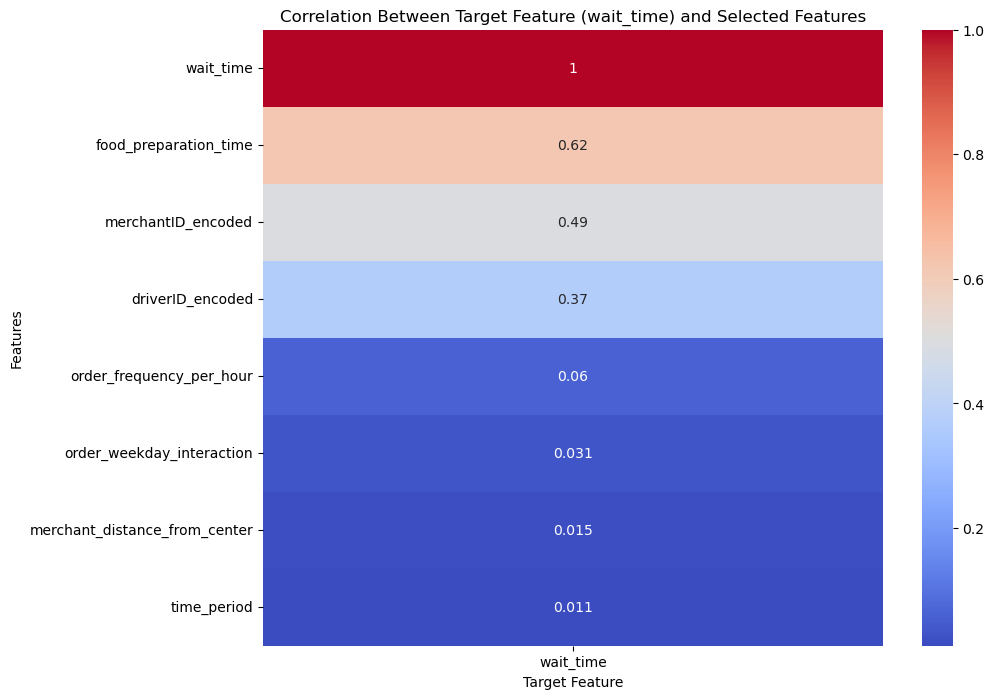

In [ ]:
#Feature correlation

selected_columns = feature_columns + [target_column]
data_selected = data[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = data_selected.corr()

# Plot the correlation between the target feature and other features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[[target_column]].sort_values(by=target_column, ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation Between Target Feature (wait_time) and Selected Features")
plt.xlabel("Target Feature")
plt.ylabel("Features")
plt.show()

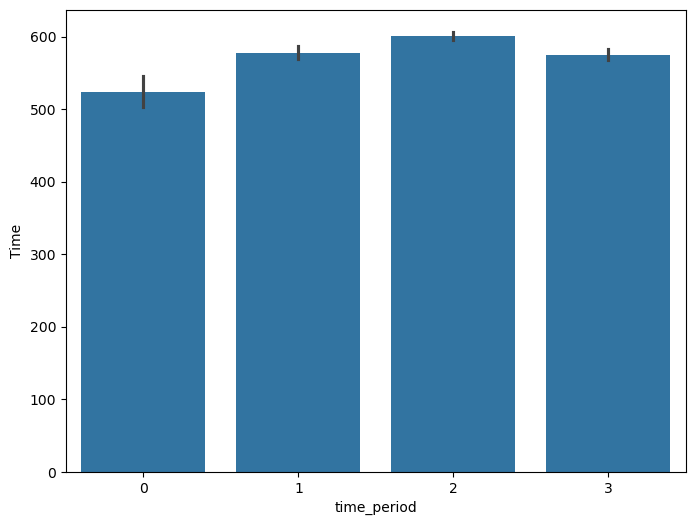

In [ ]:
#Relationship between time_period and wait_time

# Assuming 'weekend' is a boolean column and 'time' is the target variable
plt.figure(figsize=(8, 6))
sns.barplot(x='time_period', y='wait_time', data=data)
# plt.title('Box Plot of Time by Weekend')
plt.xlabel('time_period')
plt.ylabel('Time')
plt.show()


#### XGBoost

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    n_estimators=1500,              
    learning_rate=0.005,             
    max_depth=6,                   
    random_state=42,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.5,
    reg_lambda=1,   
    subsample=0.6
)


# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) 


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Squared Error (MSE): 64543.77777833287
Root Mean Squared Error (RMSE): 254.0546747814983
Mean Absolute Error (MAE): 192.6145518202502
R-Squared (R2): 0.5689739075952589
Mean Absolute Percentage Error (MAPE): 0.49488225200083136


##### feature importance

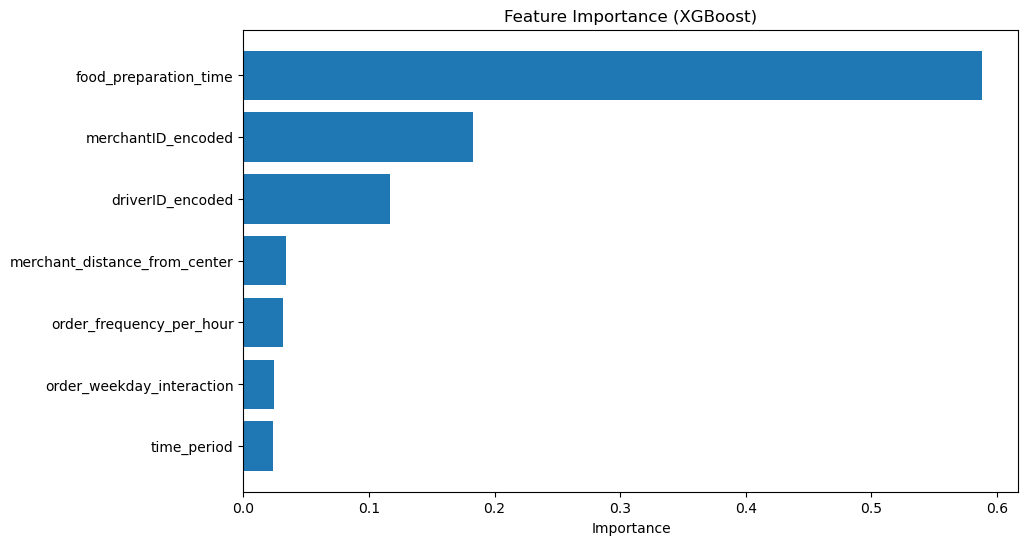

In [ ]:
feature_importances = xgboost_model.feature_importances_
features = X_train.columns

# Create a DataFrame to sort and plot feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Optional: invert y-axis for descending order
plt.show()


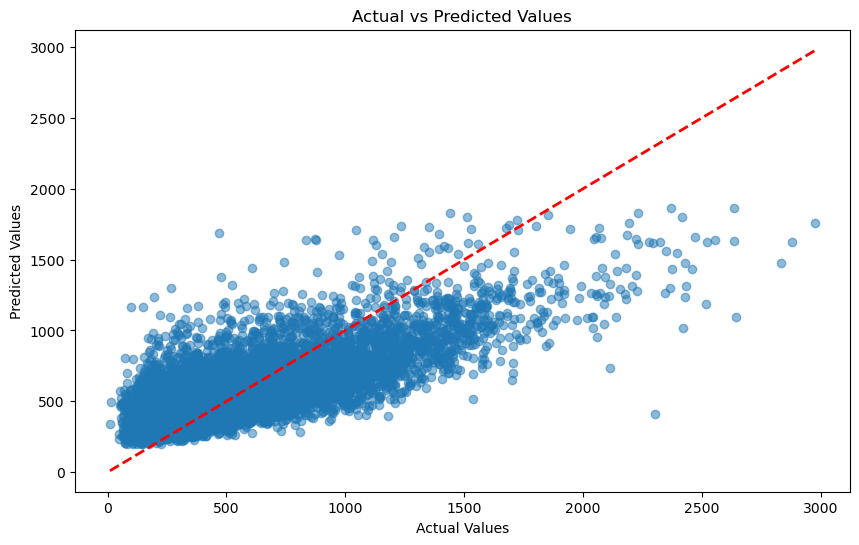

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


##### grid search

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7, 10],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.3, 0.5],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [1, 1.5, 2, 3]
# }

# # Define a custom RMSE scorer
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# # Use the custom RMSE function with make_scorer
# scoring = make_scorer(rmse, greater_is_better=False)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgboost_model,
#     param_grid=param_grid,
#     scoring=scoring,    # Use 'accuracy' for classification tasks
#     cv=3,               # 3-fold cross-validation
#     verbose=1,
#     n_jobs=-1           # Use all available cores
# )

# # Fit GridSearchCV
# grid_search.fit(X, y)

# # Print the best parameters and best RMSE score
# print("Best Parameters:", grid_search.best_params_)
# print("Best RMSE Score:", -grid_search.best_score_)

Fitting 3 folds for each of 20736 candidates, totalling 62208 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
Best RMSE Score: 371.7058182914136
